In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import cv2

In [3]:
#add google drive with dataframe
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
#data on my drive 
!ls "/content/drive/My Drive"

'Colab Notebooks'   Книги   Спирин.gdoc


In [0]:
#copy my dataframe in local drive
!cp /content/drive/'My Drive'/'Colab Notebooks'/leaf_diseases.zip .

In [6]:
!ls

drive  leaf_diseases.zip  sample_data


In [7]:
#unpacking the archive
!unzip leaf_diseases.zip

Archive:  leaf_diseases.zip
   creating: plant-pathology-2020-fgvc7/
  inflating: plant-pathology-2020-fgvc7/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/plant-pathology-2020-fgvc7/
  inflating: __MACOSX/plant-pathology-2020-fgvc7/._.DS_Store  
   creating: plant-pathology-2020-fgvc7/images/
  inflating: plant-pathology-2020-fgvc7/images/Train_1088.jpg  
   creating: __MACOSX/plant-pathology-2020-fgvc7/images/
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1088.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_364.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_364.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_1705.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1705.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_1063.jpg  
  inflating: __MACOSX/plant-pathology-2020-fgvc7/images/._Train_1063.jpg  
  inflating: plant-pathology-2020-fgvc7/images/Train_402.jpg  
  inflating: __MACOSX

In [0]:
#delete extra files
!rm -rf /content/__MACOSX

In [9]:
!ls

drive  leaf_diseases.zip  plant-pathology-2020-fgvc7  sample_data


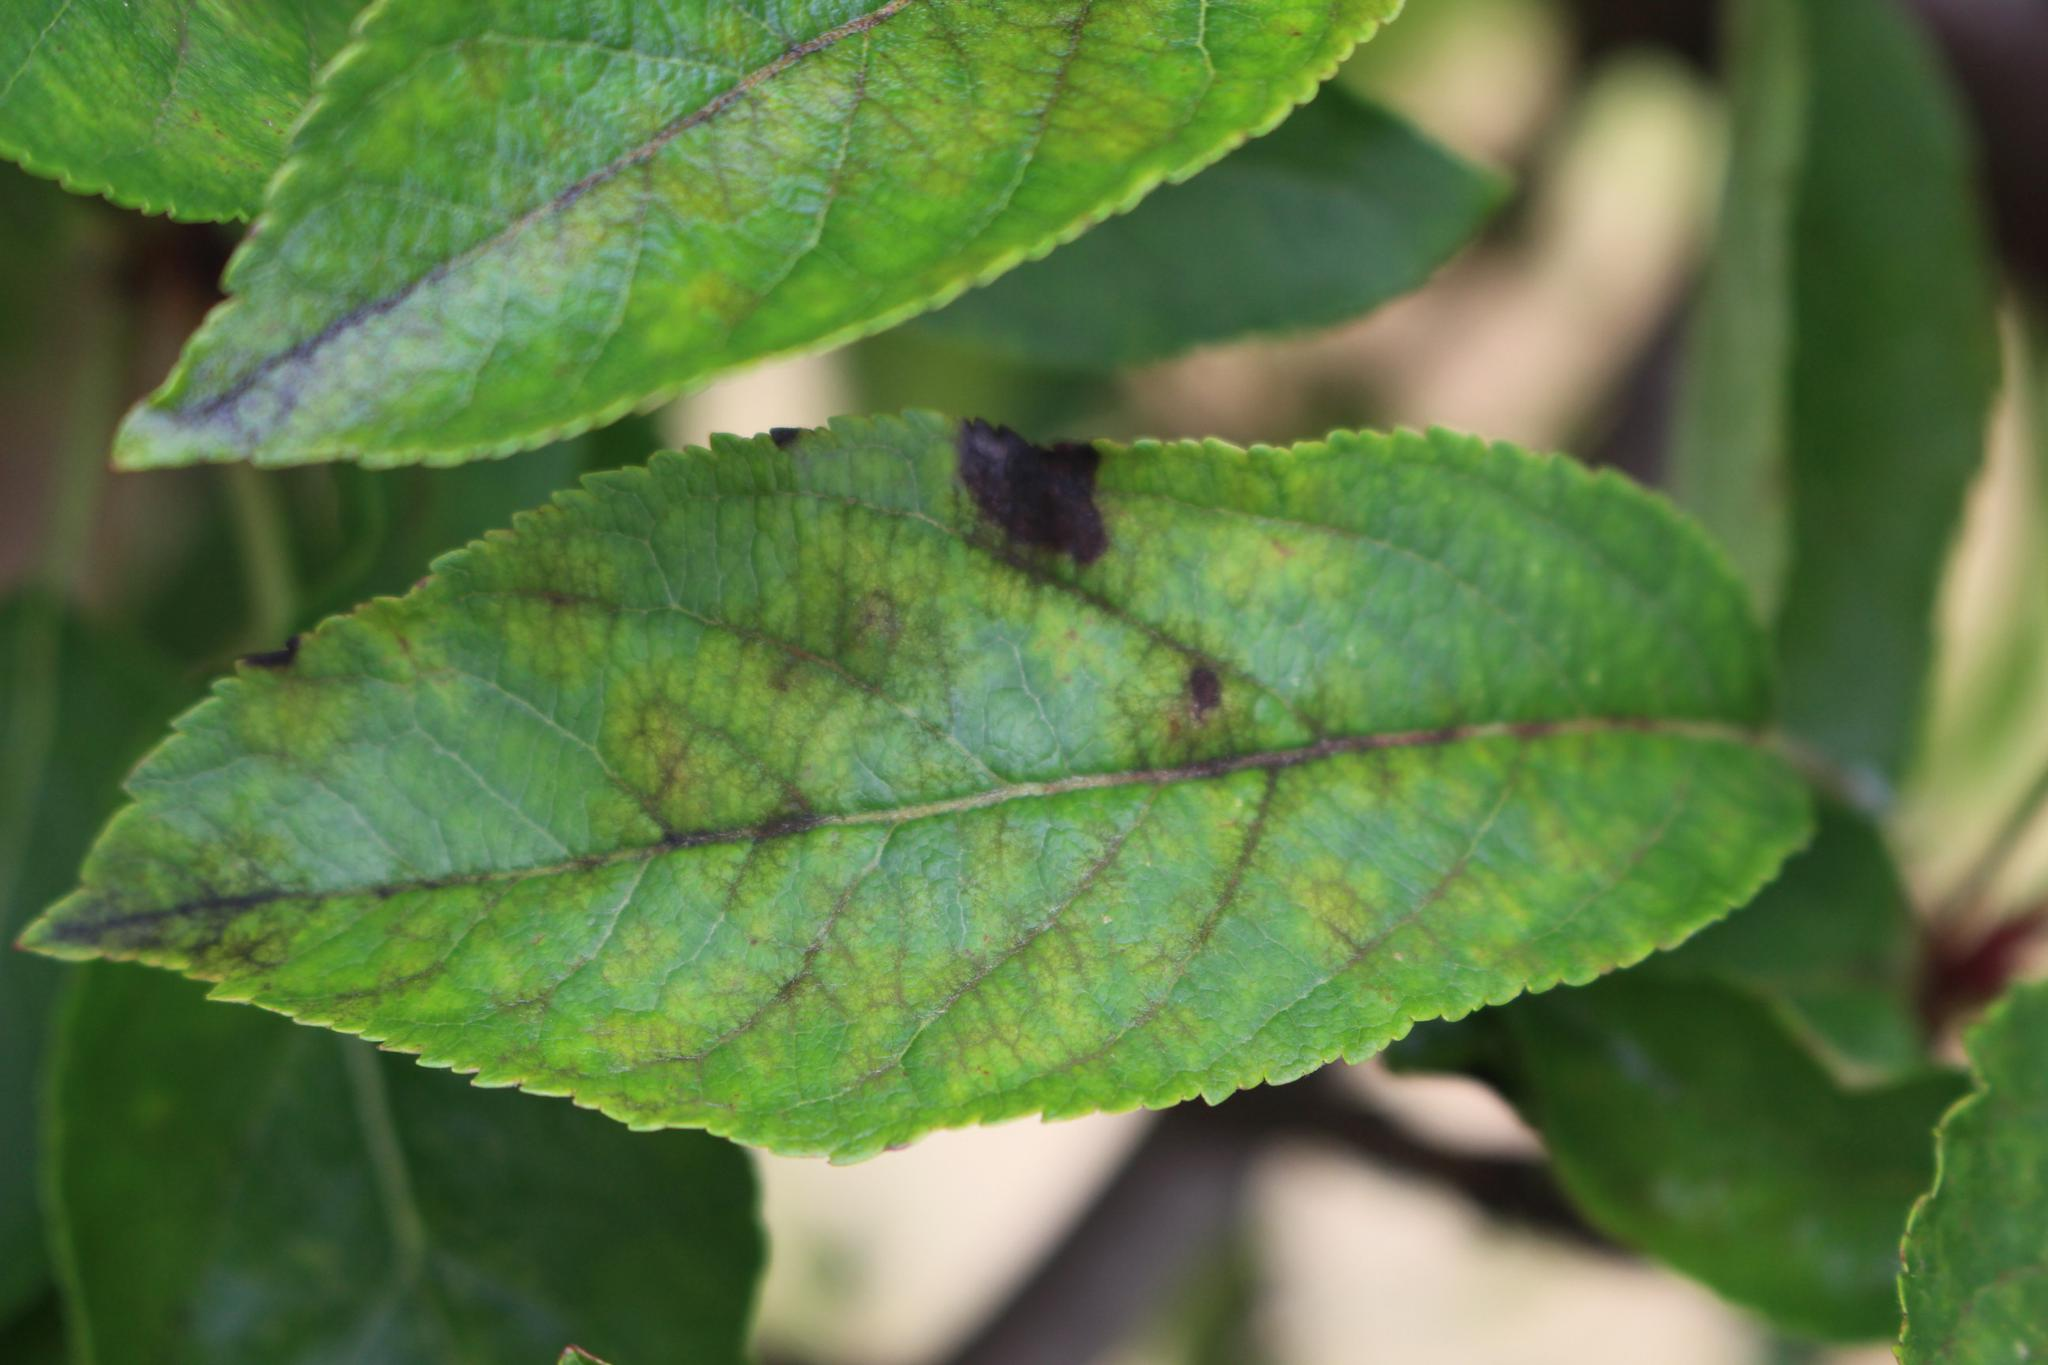

In [11]:
#show image
from IPython.display import Image
Image('plant-pathology-2020-fgvc7/images/Train_1650.jpg')

In [0]:
#connect our dataframe
df = pd.read_csv('/content/plant-pathology-2020-fgvc7/train.csv')

In [13]:
df

,image_id,healthy,multiple_diseases,rust,scab
0,Train_0,0,0,0,1
1,Train_1,0,1,0,0
2,Train_2,1,0,0,0
3,Train_3,0,0,1,0
4,Train_4,1,0,0,0
...,...,...,...,...,...
1816,Train_1816,0,0,0,1
1817,Train_1817,1,0,0,0
1818,Train_1818,1,0,0,0
1819,Train_1819,0,0,1,0


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   image_id           1821 non-null   object
 1   healthy            1821 non-null   int64 
 2   multiple_diseases  1821 non-null   int64 
 3   rust               1821 non-null   int64 
 4   scab               1821 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 71.3+ KB


### Prepare our data for train





In [0]:
target = df[['healthy', 'multiple_diseases', 'rust', 'scab']]

In [0]:
#resize image
IMAGE_PATH = "/content/plant-pathology-2020-fgvc7/images/"
def resize_image(image):
  width = 100
  height = 100
  dim = (width, height)
  return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [0]:
#function for loading images
def load_images(df):
  images = []
  for i in df['image_id']:
    image = cv2.imread(IMAGE_PATH + i + ".jpg")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(resize_image(image))
  return images

In [0]:
#load images
train_images = load_images(df)
train_images = np.array(train_images) 

In [19]:
#split data on train and test
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_images, target.to_numpy(), test_size=0.1, random_state=100) 

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1638, 100, 100, 3), (183, 100, 100, 3), (1638, 4), (183, 4))

###Preprocessing

In [20]:
from keras.preprocessing.image import ImageDataGenerator

# create generator (1.0/255.0 = 0.003921568627451)
datagen = ImageDataGenerator(rescale=1.0/255.0,
                             rotation_range=20,
                             horizontal_flip=True,
                             vertical_flip=True)

# prepare an iterators to scale images
train_iterator = datagen.flow(x_train, y_train, batch_size=64)
test_iterator = datagen.flow(x_test, y_test, batch_size=64)
print('Batches train=%d, test=%d' % (len(train_iterator), len(test_iterator)))

Using TensorFlow backend.


Batches train=26, test=3


###Train without dropout

In [28]:
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation, Dense
from keras import layers
from keras import models

model = models.Sequential() 
model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2))) 
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(Dense(4, activation='softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_9 (Batch (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_10 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 21, 21, 128)      

In [29]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history = model.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),
                    epochs=50)
_, acc, precision, recall = model.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
print('Test Accuracy: %.3f' % (acc * 100))
print('Test Precision: %.3f' % (precision * 100))
print('Test Recall: %.3f' % (recall * 100))

Epoch 1/50
26/26 [==============================] - 44s 2s/step - loss: 2.0520 - acc: 0.4023 - precision_2: 0.3707 - recall_2: 0.3210
Epoch 2/50
26/26 [==============================] - 43s 2s/step - loss: 1.1553 - acc: 0.5043 - precision_2: 0.4557 - recall_2: 0.3432
Epoch 3/50
26/26 [==============================] - 43s 2s/step - loss: 1.0699 - acc: 0.5311 - precision_2: 0.4988 - recall_2: 0.3501
Epoch 4/50
26/26 [==============================] - 43s 2s/step - loss: 0.9817 - acc: 0.5824 - precision_2: 0.5348 - recall_2: 0.3699
Epoch 5/50
26/26 [==============================] - 46s 2s/step - loss: 0.9130 - acc: 0.6209 - precision_2: 0.5663 - recall_2: 0.3925
Epoch 6/50
26/26 [==============================] - 43s 2s/step - loss: 0.7533 - acc: 0.7063 - precision_2: 0.6014 - recall_2: 0.4269
Epoch 7/50
26/26 [==============================] - 43s 2s/step - loss: 0.6303 - acc: 0.7680 - precision_2: 0.6322 - recall_2: 0.4607
Epoch 8/50
26/26 [==============================] - 43s 2s/ste

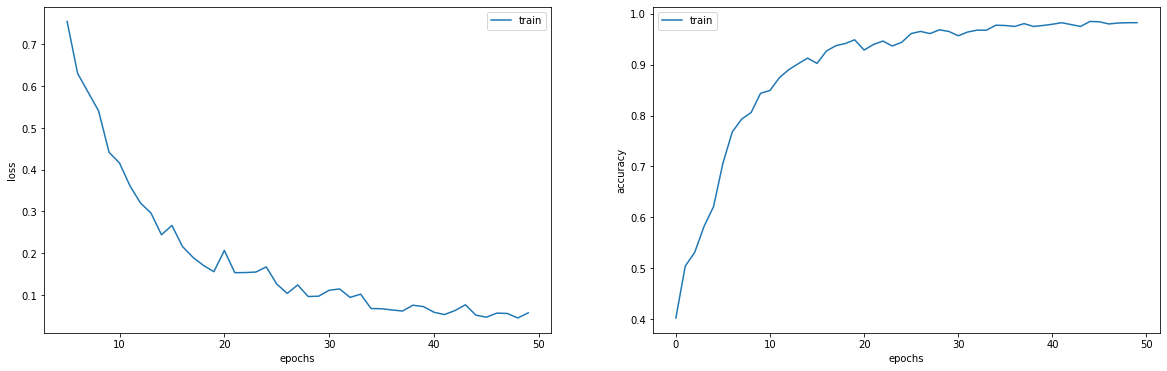

In [30]:
from matplotlib import pyplot as plt

h = history.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'acc'], label='train')
plt.legend()

plt.show()

### Train with dropout 0.25

In [33]:
from keras.layers import Dropout

model2 = models.Sequential() 
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2))) 
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(BatchNormalization(axis=-1))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(Dropout(0.25))
model2.add(layers.Flatten()) 
model2.add(layers.Dense(512, activation='relu'))
model2.add(Dense(4, activation='softmax'))
model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 21, 21, 128)      

In [34]:
model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history2 = model2.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),
                    epochs=50)
_, acc2, precision2, recall2 = model2.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
print('Test Accuracy: %.3f' % (acc2 * 100))
print('Test Precision: %.3f' % (precision2 * 100))
print('Test Recall: %.3f' % (recall2 * 100))

Epoch 1/50
26/26 [==============================] - 44s 2s/step - loss: 2.0454 - acc: 0.4035 - precision_4: 0.4040 - recall_4: 0.3624
Epoch 2/50
26/26 [==============================] - 43s 2s/step - loss: 1.2800 - acc: 0.4902 - precision_4: 0.4425 - recall_4: 0.3701
Epoch 3/50
26/26 [==============================] - 43s 2s/step - loss: 1.0119 - acc: 0.5763 - precision_4: 0.4982 - recall_4: 0.4038
Epoch 4/50
26/26 [==============================] - 43s 2s/step - loss: 0.8745 - acc: 0.6484 - precision_4: 0.5446 - recall_4: 0.4388
Epoch 5/50
26/26 [==============================] - 43s 2s/step - loss: 0.7358 - acc: 0.7094 - precision_4: 0.5890 - recall_4: 0.4797
Epoch 6/50
26/26 [==============================] - 44s 2s/step - loss: 0.6091 - acc: 0.7643 - precision_4: 0.6259 - recall_4: 0.5172
Epoch 7/50
26/26 [==============================] - 43s 2s/step - loss: 0.5332 - acc: 0.8034 - precision_4: 0.6579 - recall_4: 0.5510
Epoch 8/50
26/26 [==============================] - 44s 2s/ste

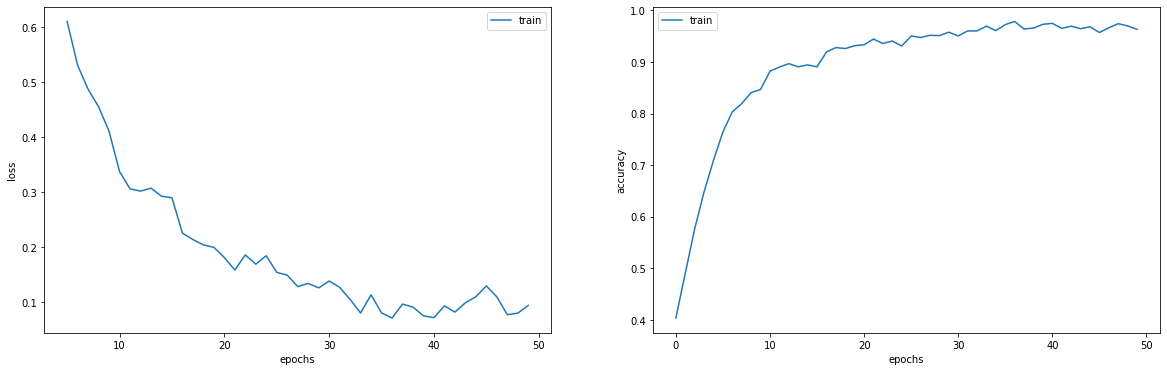

In [35]:
from matplotlib import pyplot as plt

h = history2.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'acc'], label='train')
plt.legend()

plt.show()

###Train with dropout 0.4

In [36]:
model3 = models.Sequential() 
model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model3.add(BatchNormalization(axis=-1))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(BatchNormalization(axis=-1))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization(axis=-1))
model3.add(layers.MaxPooling2D((2, 2))) 
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(BatchNormalization(axis=-1))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(Dropout(0.4))
model3.add(layers.Flatten()) 
model3.add(layers.Dense(512, activation='relu'))
model3.add(Dense(4, activation='softmax'))
model3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_21 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_22 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 21, 21, 128)      

In [37]:
model3.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history3 = model3.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),
                    epochs=50)
_, acc2, precision2, recall2 = model3.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
print('Test Accuracy: %.3f' % (acc2 * 100))
print('Test Precision: %.3f' % (precision2 * 100))
print('Test Recall: %.3f' % (recall2 * 100))

Epoch 1/50
26/26 [==============================] - 44s 2s/step - loss: 2.3634 - acc: 0.4029 - precision_5: 0.3677 - recall_5: 0.3270
Epoch 2/50
26/26 [==============================] - 43s 2s/step - loss: 1.2703 - acc: 0.5079 - precision_5: 0.4511 - recall_5: 0.3901
Epoch 3/50
26/26 [==============================] - 45s 2s/step - loss: 0.9788 - acc: 0.6215 - precision_5: 0.5096 - recall_5: 0.4252
Epoch 4/50
26/26 [==============================] - 43s 2s/step - loss: 0.8010 - acc: 0.6941 - precision_5: 0.5669 - recall_5: 0.4710
Epoch 5/50
26/26 [==============================] - 43s 2s/step - loss: 0.6975 - acc: 0.7357 - precision_5: 0.6101 - recall_5: 0.5114
Epoch 6/50
26/26 [==============================] - 43s 2s/step - loss: 0.6215 - acc: 0.7564 - precision_5: 0.6446 - recall_5: 0.5469
Epoch 7/50
26/26 [==============================] - 43s 2s/step - loss: 0.5396 - acc: 0.8132 - precision_5: 0.6715 - recall_5: 0.5770
Epoch 8/50
26/26 [==============================] - 43s 2s/ste

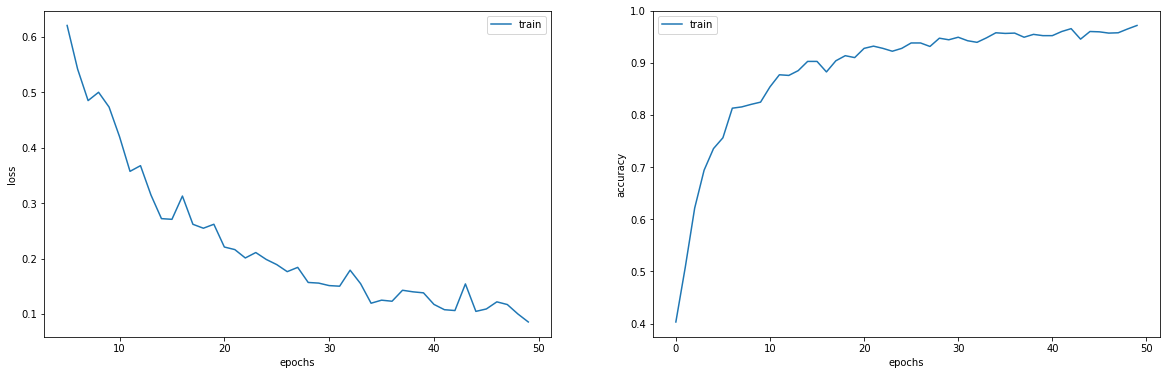

In [38]:
from matplotlib import pyplot as plt

h = history3.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'acc'], label='train')
plt.legend()

plt.show()

###Train with dropout 0.5

In [39]:
model4 = models.Sequential() 
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(100, 100, 3)))
model4.add(BatchNormalization(axis=-1))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(BatchNormalization(axis=-1))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization(axis=-1))
model4.add(layers.MaxPooling2D((2, 2))) 
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(BatchNormalization(axis=-1))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(Dropout(0.5))
model4.add(layers.Flatten()) 
model4.add(layers.Dense(512, activation='relu'))
model4.add(Dense(4, activation='softmax'))
model4.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization_25 (Batc (None, 98, 98, 32)        128       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 47, 47, 64)        18496     
_________________________________________________________________
batch_normalization_26 (Batc (None, 47, 47, 64)        256       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 21, 21, 128)      

In [40]:
model4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

history4 = model4.fit_generator(train_iterator, steps_per_epoch=len(train_iterator),
                    epochs=50)
_, acc2, precision2, recall2 = model4.evaluate_generator(test_iterator, steps=len(test_iterator), verbose=0)
print('Test Accuracy: %.3f' % (acc2 * 100))
print('Test Precision: %.3f' % (precision2 * 100))
print('Test Recall: %.3f' % (recall2 * 100))

Epoch 1/50
26/26 [==============================] - 44s 2s/step - loss: 2.5341 - acc: 0.4182 - precision_6: 0.3822 - recall_6: 0.3563
Epoch 2/50
26/26 [==============================] - 43s 2s/step - loss: 1.4795 - acc: 0.4670 - precision_6: 0.4459 - recall_6: 0.4037
Epoch 3/50
26/26 [==============================] - 43s 2s/step - loss: 1.1385 - acc: 0.5617 - precision_6: 0.4849 - recall_6: 0.4238
Epoch 4/50
26/26 [==============================] - 43s 2s/step - loss: 0.8779 - acc: 0.6349 - precision_6: 0.5314 - recall_6: 0.4541
Epoch 5/50
26/26 [==============================] - 43s 2s/step - loss: 0.7729 - acc: 0.7045 - precision_6: 0.5720 - recall_6: 0.4870
Epoch 6/50
26/26 [==============================] - 45s 2s/step - loss: 0.6928 - acc: 0.7308 - precision_6: 0.6063 - recall_6: 0.5179
Epoch 7/50
26/26 [==============================] - 43s 2s/step - loss: 0.6634 - acc: 0.7534 - precision_6: 0.6340 - recall_6: 0.5451
Epoch 8/50
26/26 [==============================] - 43s 2s/ste

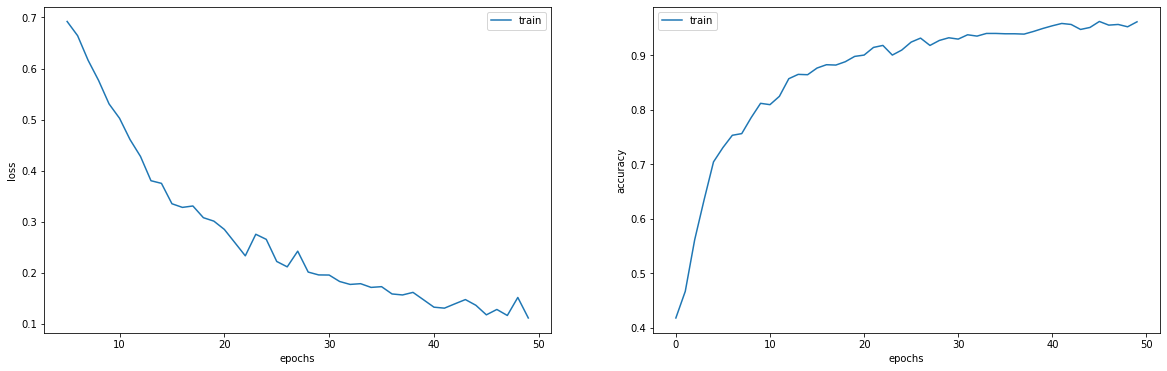

In [41]:
from matplotlib import pyplot as plt

h = history4.history

offset = 5
epochs = range(offset, len(h['loss']))

plt.figure(1, figsize=(20, 6))

plt.subplot(121)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(epochs, h['loss'][offset:], label='train')
plt.legend()

plt.subplot(122)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(h[f'acc'], label='train')
plt.legend()

plt.show()

###Train with dropout and without dropout

We can see that training with dropout can give as better accurasy on test data (89% with dropout and 82% without it). But we must be neat with dropout's meanings. On first train I use meanings 0.2 and it don't give me better accurasy. With dropout 0.25 we can take accurasy 84%, with dropout 0.4 we have very good result 89% (82% without it). But dropout 0.5 shows us worse accurasy, because it drops a lot of data.

###Feature maps

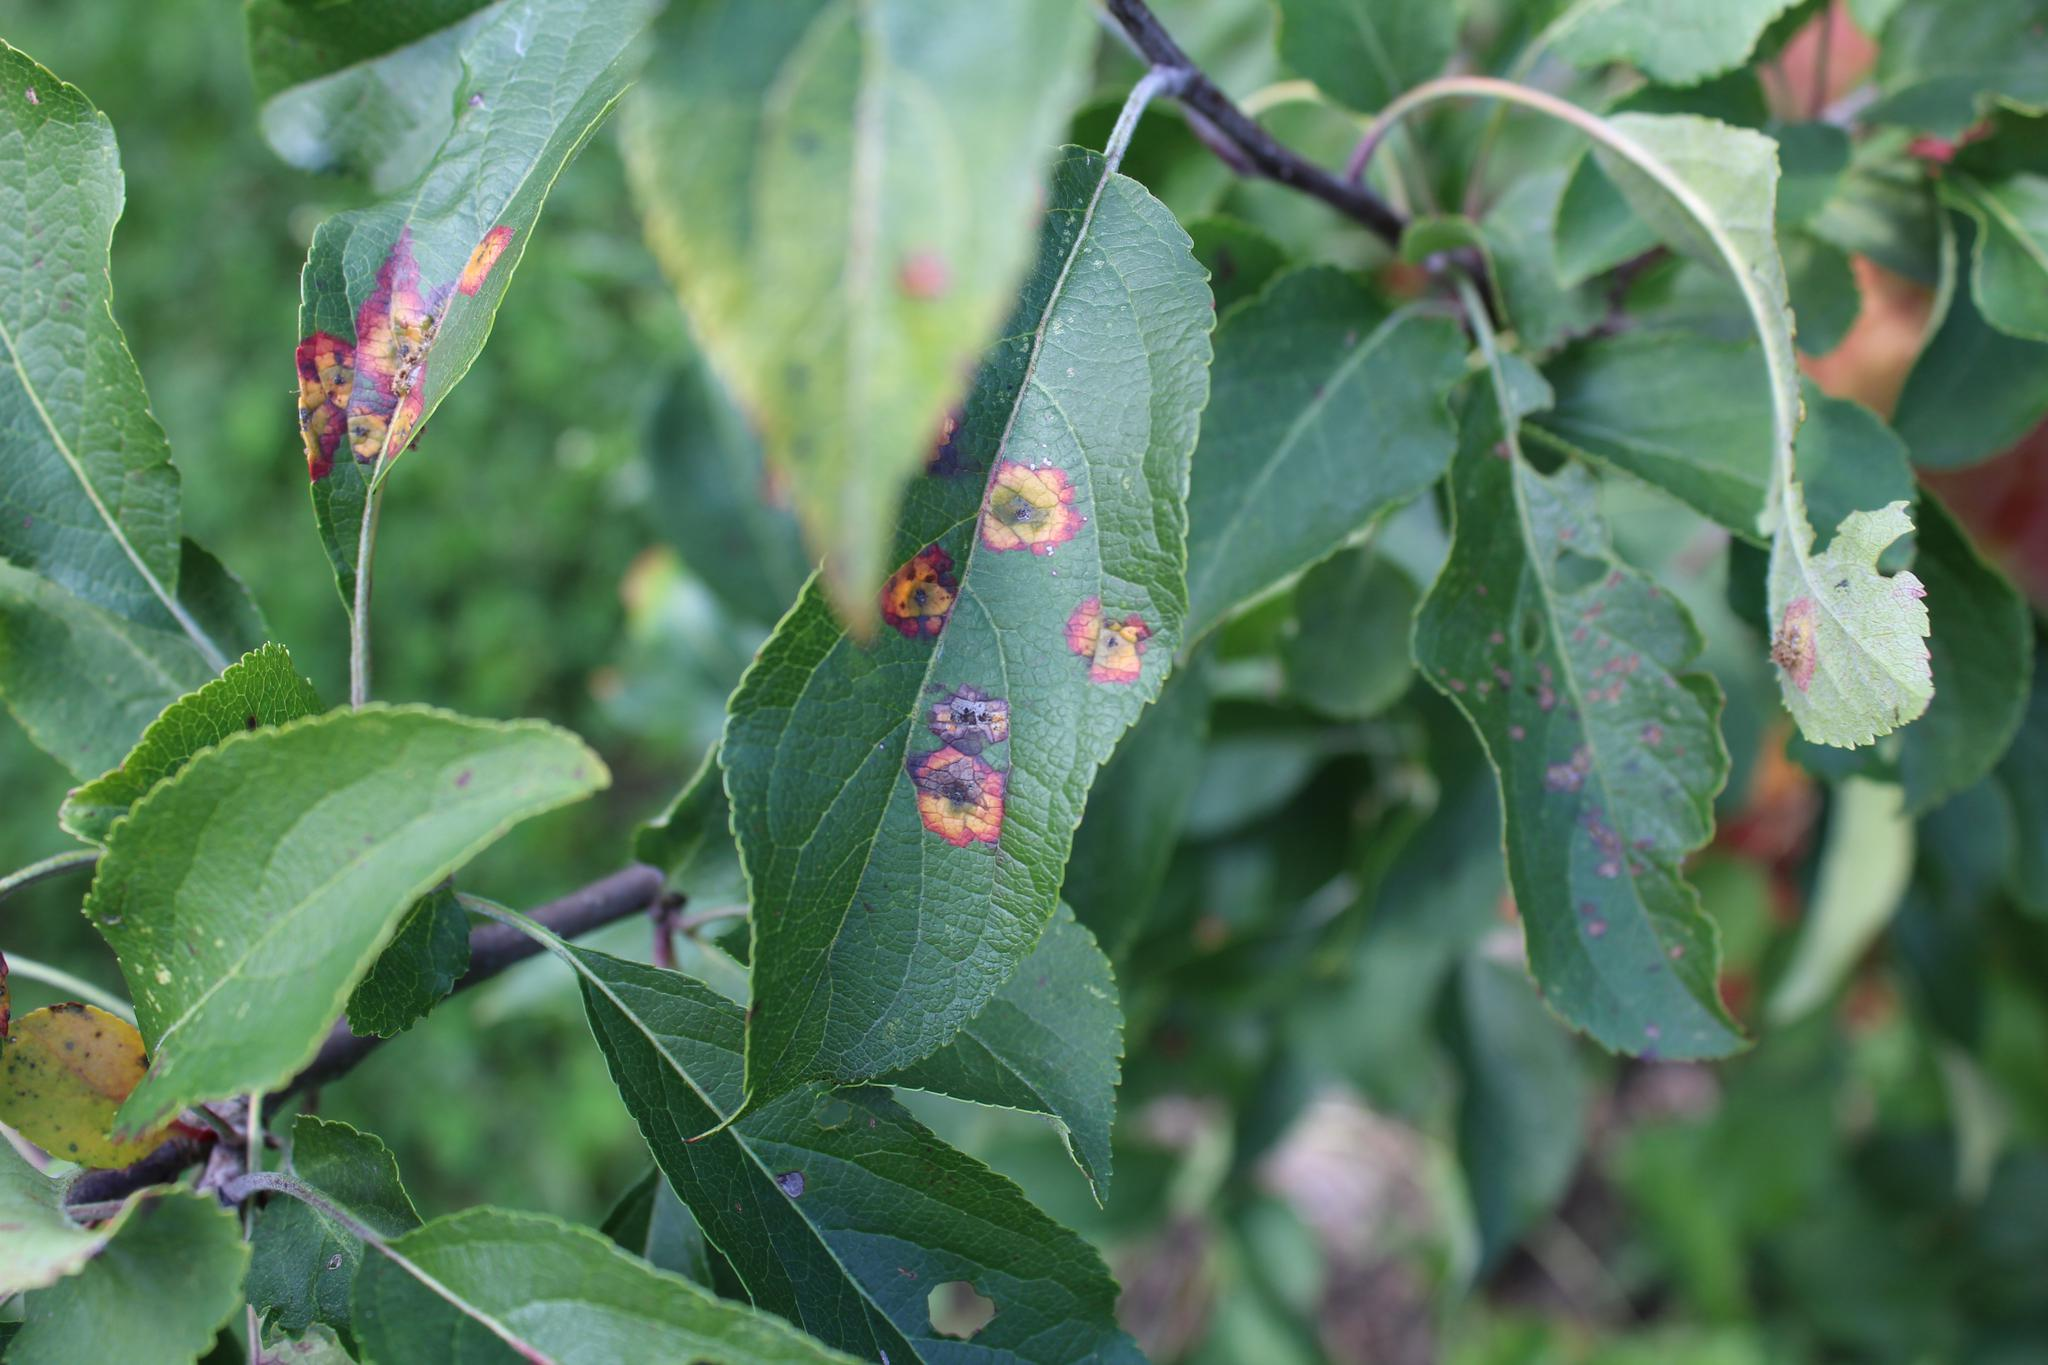

In [156]:
Image('/content/drive/My Drive/Colab Notebooks/test_image/Test_1000.jpg')

In [0]:
test_image = cv2.imread("/content/drive/My Drive/Colab Notebooks/test_image/Test_1000.jpg")
test_image = resize_image(test_image)
test_image = np.expand_dims(test_image, axis=0)

In [0]:
from keras.models import Model

index = [0, 3, 6, 9]
outputs = [model3.layers[i].output for i in index]
model_FMaps = Model(inputs=model3.inputs, outputs=outputs)

In [0]:
feature_maps = model_FMaps.predict(test_image)

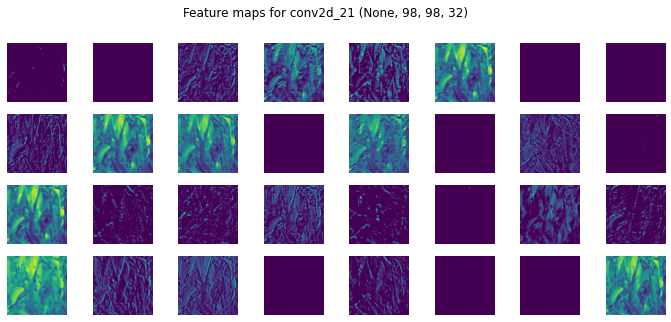

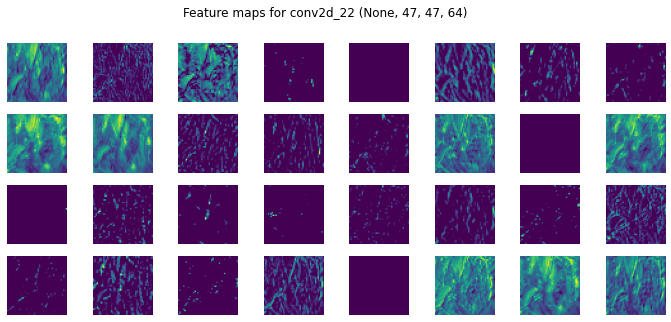

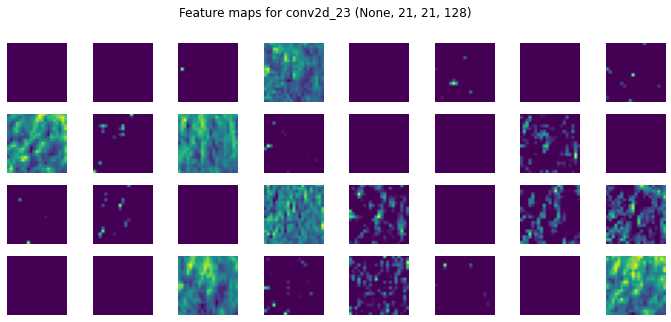

In [186]:
for layer_id in range(3):
    n_rows=4
    n_col=8
    figsize=(12,5)
    layer = model3.layers[index[layer_id]]
    plt.figure(figsize=figsize)
    plt.suptitle('Feature maps for %s %s' % (layer.name, layer.output.shape))
    ix = 1
    for _ in range(n_rows):
        for _ in range(n_col):
            # specify subplot and turn of axis
            plt.subplot(n_rows, n_col, ix)
            plt.axis('off')
            # plot filter channel in grayscale
            plt.imshow(feature_maps[layer_id][0, :, :, ix-1])
            ix += 1
    # show the figure
    plt.show()

###Image prediction

In [0]:
# Class 0 is healthy
# Class 1 is multiple_diseases
# Class 2 is rust
# Class 3 is scab

In [176]:
result_image = cv2.imread("/content/drive/My Drive/Colab Notebooks/test_image/Test_1000.jpg")
result_image = resize_image(result_image)
result_image = np.expand_dims(result_image, axis=0)
pred = model3.predict_classes(result_image)
print(pred)

[2]
